# 淘宝用户行为分析

## 阶段一: 明确业务问题&分析目标&分析思路

数据集：淘宝用户行为（通常包含 user_id, item_id, category_id, behavior_type, timestamp 等字段）

🔗 数据来源：https://tianchi.aliyun.com/dataset/649

📔数据描述：本数据集包含了2017年11月25日至2017年12月3日之间，有行为的约一百万随机用户的所有行为（行为包括点击、购买、加购、喜欢）。数据集的组织形式和MovieLens-20M类似，即数据集的每一行表示一条用户行为，由用户ID、商品ID、商品类目ID、行为类型和时间戳组成，并以逗号分隔。关于数据集中每一列的详细描述如下

**业务背景**：本项目基于阿里巴巴开源的淘宝用户行为数据集，模拟电商平台的用户行为分析，目标是理解用户在电商平台的行为模式（浏览、点击、加购、购买），并提出优化用户转化和留存的可行性建议。

## 阶段二：理解数据 & 数据清洗

### 字段理解

1. 用户ID（user_id）：整数类型
2. 商品ID（item_id）：整数类型
3. 商品类目ID（item_category）：整数类型
4. 行为类型（behavior_type）：字符串，枚举类型，包括（`pv`, `buy`,`cart`,`fav`）
5. 时间戳（timestamp）：行为发生的时间戳

**行为类型**：
1. `pv`：商品详情页pv，等价于点击
2. `fav`：收藏商品
3. `cart`：将商品加入购物车
4. `buy`：商品购买


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
from pyspark.sql import SparkSession

# from data_analysis import user_behavior
%matplotlib inline

from pyspark.sql import SparkSession

def create_spark(app_name="MyApp", master="local[4]", driver_memory="8g", ui_port=4050):
    spark = (
        SparkSession.builder
            .appName(app_name)
            # 本地模式
            .master(master)
            # 避免因 IP 解析错误导致 RpcEndpointNotFoundException
            .config("spark.driver.bindAddress", "127.0.0.1")
            .config("spark.driver.host", "127.0.0.1")
            # 调整内存配置
            .config("spark.sql.shuffle.partitions", "8")
            .config("spark.driver.memory", driver_memory)
            .config("spark.executor.memory", driver_memory)  # executor 内存也配同样大小
            # 避免 Spark UI 端口冲突 (默认 4040)
            .config("spark.ui.port", str(ui_port))
            # 避免 SQL 执行时的严格 ANSI 检查
            .config("spark.sql.ansi.enabled", "false")
            # 可选：提高并行度 (适合 CPU 核数多时)
            .config("spark.sql.shuffle.partitions", "8")
            .getOrCreate()
    )
    return spark


# 使用方法
spark = create_spark()
print("SparkSession 已创建 ✅")
spark.conf.set("spark.sql.session.timeZone", "Asia/Shanghai")

/Users/yujiewang/anaconda3/envs/Conda11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/10 09:42:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
taobao = spark.read.csv('data/UserBehavior.csv', header=None, inferSchema=True)
# inferSchema - # 自动推断数据类型（可选，加快调试）
taobao = taobao.toDF("user_id", "item_id", "item_category", "behavior_type", "timestamp")
taobao.show(5,0)

In [2]:
taobao_pd = pd.read_csv("data/UserBehavior.csv", names=['user_id','item_id','item_category','behavior_type','timestamp'])
taobao_pd.head(5)

+-------+-------+-------------+-------------+----------+
|user_id|item_id|item_category|behavior_type|timestamp |
+-------+-------+-------------+-------------+----------+
|1      |2268318|2520377      |pv           |1511544070|
|1      |2333346|2520771      |pv           |1511561733|
|1      |2576651|149192       |pv           |1511572885|
|1      |3830808|4181361      |pv           |1511593493|
|1      |4365585|2520377      |pv           |1511596146|
+-------+-------+-------------+-------------+----------+
only showing top 5 rows


In [3]:
# 查看列名和数据类型
taobao.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_category: integer (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- timestamp: integer (nullable = true)



In [4]:
# 查看总行数和列数
taobao_pd.shape

总行数: 100150807 
 总列数: 5


In [5]:
taobao_pd.describe()

25/09/10 09:43:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-------------+--------------------+
|summary|           user_id|           item_id|     item_category|behavior_type|           timestamp|
+-------+------------------+------------------+------------------+-------------+--------------------+
|  count|         100150807|         100150807|         100150807|    100150807|           100150807|
|   mean|506943.12166863517|2579774.7998742834|  2696380.39171917|         NULL|1.5119512768722115E9|
| stddev| 294060.5026583998|1488055.9874815156|1463154.5235416417|         NULL|   5528006.068990402|
|    min|                 1|                 1|                80|          buy|         -2134949234|
|    max|           1018011|           5163070|           5162429|           pv|          2122867355|
+-------+------------------+------------------+------------------+-------------+--------------------+



### 数据清洗

**清洗的步骤**：
1. 导入数据
2. 查看数据结构
3. 缺失值检查——补缺/去除缺失值
4. 重复值检查——去重
5. 异常值检查
6. 数据类型转换 —— data transformation
7. 创建新字段

In [6]:
# 检查缺失值
from pyspark.sql.functions import *
# print("非空值情况:")
# notnull_counts = taobao.select([count(col(c)).alias(c) for c in taobao.columns])
# notnull_counts.show()

非空值情况:


+---------+---------+-------------+-------------+---------+
|  user_id|  item_id|item_category|behavior_type|timestamp|
+---------+---------+-------------+-------------+---------+
|100150807|100150807|    100150807|    100150807|100150807|
+---------+---------+-------------+-------------+---------+



In [7]:
print("缺失值情况：")
null_counts = taobao.select([sum(col(c).isNull().cast('int')).alias(c) for c in taobao.columns])
null_counts.show()

缺失值情况：


+-------+-------+-------------+-------------+---------+
|user_id|item_id|item_category|behavior_type|timestamp|
+-------+-------+-------------+-------------+---------+
|      0|      0|            0|            0|        0|
+-------+-------+-------------+-------------+---------+



In [8]:
# 去重
taobao = taobao.distinct()
taobao.show(5)

+-------+-------+-------------+-------------+----------+
|user_id|item_id|item_category|behavior_type| timestamp|
+-------+-------+-------------+-------------+----------+
|1000001|4636765|      3004853|           pv|1511965786|
|1000004|1591982|       672001|           pv|1511571841|
|1000004|1317750|      1080785|         cart|1511966265|
| 100002|3065876|       772894|           pv|1511955270|
|1000028|2826485|      2940518|           pv|1512314891|
+-------+-------+-------------+-------------+----------+
only showing top 5 rows


In [9]:
# 转换数据类型——时间戳
taobao = taobao.withColumn("time", from_unixtime("timestamp").cast("timestamp"))
taobao = taobao.withColumns({'date':to_date('time'),'hour':hour('time'), 'weekday':date_format('time','EEEE')})
taobao.show(5)

+-------+-------+-------------+-------------+----------+-------------------+----------+----+---------+
|user_id|item_id|item_category|behavior_type| timestamp|               time|      date|hour|  weekday|
+-------+-------+-------------+-------------+----------+-------------------+----------+----+---------+
|1000001|4636765|      3004853|           pv|1511965786|2017-11-29 22:29:46|2017-11-29|  22|Wednesday|
|1000004|1591982|       672001|           pv|1511571841|2017-11-25 09:04:01|2017-11-25|   9| Saturday|
|1000004|1317750|      1080785|         cart|1511966265|2017-11-29 22:37:45|2017-11-29|  22|Wednesday|
| 100002|3065876|       772894|           pv|1511955270|2017-11-29 19:34:30|2017-11-29|  19|Wednesday|
|1000028|2826485|      2940518|           pv|1512314891|2017-12-03 23:28:11|2017-12-03|  23|   Sunday|
+-------+-------+-------------+-------------+----------+-------------------+----------+----+---------+
only showing top 5 rows


In [10]:
# 检查日期范围
minmaxdate = taobao.agg(
    min('time').alias('min_date'),
    max('time').alias('max_date'),
).collect()[0]
min_date = minmaxdate['min_date']
max_date = minmaxdate['max_date']
print(f"日期范围: {min_date} - {max_date}")

日期范围: 1902-05-08 06:32:46 - 2037-04-09 13:22:35


In [11]:
# 筛选出指定日期的范围，过滤异常值
import datetime
start_day = datetime.date(2017,11,25)
end_day = datetime.date(2017,12,3)

taobao = taobao.filter(
    (col('date')>=start_day)&(col('date')<=end_day)
)

counts = taobao.count()
print(f"筛选后剩余的数据数量:{counts}")

筛选后剩余的数据数量:100095182


In [12]:
print(f"数据集跨度时间：{(end_day-start_day).days+1}天")

数据集跨度时间：9天


## 阶段三：探索性数据分析（EDA）

角度：
- 用户数据
    - 新增用户
    - 留存用户
    - 活跃用户
- 行为数据
    - PV/UV
    - 转发率
    - 转化率
    - K因子
- 产品数据
    - 业务总量：成交总额（GMV），成交总量，访问时长
    - 人均付费：客单价，付费人群人均付费，人均访问时长
    - 付费：付费率，复购率，回购率

分析目标：
1. 数据整体结构：用户数、商品数、行为数分布情况
2.	行为特征分析：pv/cart/fav/buy 占比、趋势
3.	时间规律分析：按天、小时的活跃度
4.	用户维度探索：活跃用户数、行为次数分布
5.	商品维度探索：Top 热门商品/类别

### 数据分布情况

In [13]:
total_user = taobao.select('user_id').distinct().count()
print(f"总用户数:{total_user}")

total_items = taobao.select('item_id').distinct().count()
print(f"总商品数:{total_items}")

total_categories = taobao.select('item_category').distinct().count()
print(f"总类别数:{total_categories}")

总用户数:987991


总商品数:4161138


总类别数:9437


In [14]:
# 行为分布
from pyspark.sql.window import Window

behaviors = taobao.groupBy('behavior_type').agg(count("behavior_type").alias('counts'))

# 使用窗口函数
# window_spec = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
#
# behaviors = behaviors.withColumn("fraction", round(behaviors['counts']/sum("counts").over(window_spec),3))

total_count = behaviors.agg(sum('counts').alias('total')).collect()[0]["total"]
behaviors = behaviors.withColumn("fraction", round(behaviors['counts']/lit(total_count),3))
behaviors.show()


+-------------+--------+--------+
|behavior_type|  counts|fraction|
+-------------+--------+--------+
|          buy| 2015807|    0.02|
|          fav| 2888258|   0.029|
|         cart| 5530446|   0.055|
|           pv|89660671|   0.896|
+-------------+--------+--------+



Text(0, 0.5, 'Count')

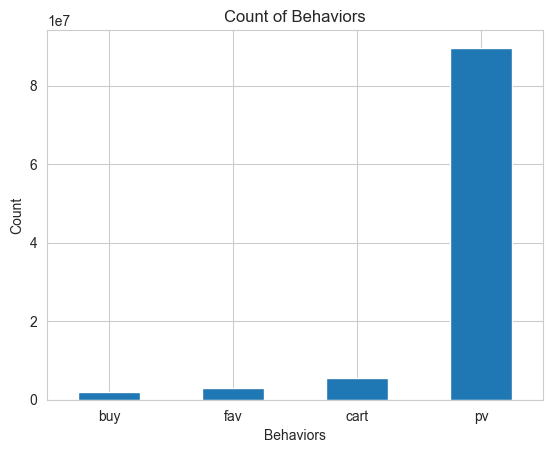

In [15]:
# 行为分布条形图
behaviors_pd = behaviors.toPandas()

fig, ax = plt.subplots()
behaviors_pd.plot.bar(x='behavior_type', y='counts', rot=0, ax=ax, legend=False)
ax.set_title('Count of Behaviors')
ax.set_xlabel('Behaviors')
ax.set_ylabel('Count')

In [16]:
behaviors.coalesce(1).write.mode("overwrite").option("header", True).csv("output/behaviors")

Text(0, 0.5, 'Density')

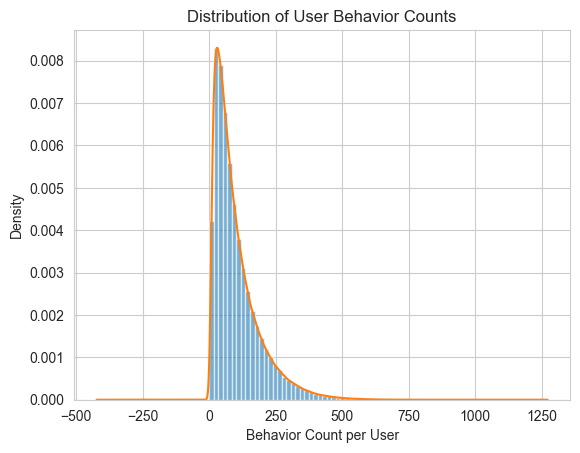

In [17]:
# 用户行为次数分布
user_beh_count = taobao.groupby('user_id').agg(count("user_id").alias("count"))
user_beh_count_pd = user_beh_count.toPandas()

fig, ax = plt.subplots()
user_beh_count_pd["count"].plot.hist(density=True,bins=50, ax=ax, alpha=0.6)
user_beh_count_pd["count"].plot.density(ax=ax)

ax.set_title("Distribution of User Behavior Counts")
ax.set_xlabel("Behavior Count per User")
ax.set_ylabel("Density")


### 时间规律分析

计算每天的活跃度、每小时活跃度

活跃度：只要用户登录——有行为数据，表示有活跃

In [18]:
# 每天的活跃用户数
daily_user = taobao.groupby('date').agg(count_distinct('user_id').alias('active'))
daily_user.show()

25/09/10 10:08:53 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 128480 ms exceeds timeout 120000 ms
25/09/10 10:08:53 WARN SparkContext: Killing executors is not supported by current scheduler.
25/09/10 10:08:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

+----------+------+
|      date|active|
+----------+------+
|2017-12-02|970401|
|2017-11-26|715516|
|2017-12-03|966977|
|2017-11-30|730597|
|2017-11-29|718922|
|2017-11-25|706641|
|2017-11-28|709257|
|2017-12-01|740139|
|2017-11-27|710094|
+----------+------+



25/09/10 10:11:17 ERROR Inbox: Ignoring error                      (0 + 2) / 28]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apach

Text(0, 0.5, '活跃用户数')

<Figure size 1000x600 with 0 Axes>

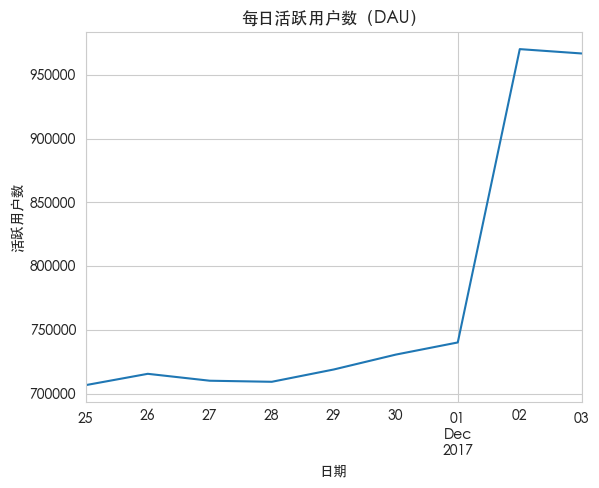

In [19]:
plt.rcParams['font.family'] = 'Heiti TC'

daily_user_pd = daily_user.toPandas()
daily_user_pd.sort_values(by='date', ascending=True, inplace=True)
daily_user_pd['date'] = pd.to_datetime(daily_user_pd['date'], format="%Y-%m-%d")

plt.figure(figsize=(10,6))
daily_user_pd.plot(x='date', y='active',legend=False)
plt.title('每日活跃用户数（DAU）')
plt.xlabel('日期')
plt.ylabel('活跃用户数')

In [20]:
# 查看日期对应的星期名
daily_user = daily_user.withColumn("weekday", date_format('date',"EEEE"))
daily_user = daily_user.sort("date", ascending=True)
daily_user.show()

25/09/10 10:12:37 ERROR Inbox: Ignoring error                      (0 + 2) / 28]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apach

+----------+------+---------+
|      date|active|  weekday|
+----------+------+---------+
|2017-11-25|706641| Saturday|
|2017-11-26|715516|   Sunday|
|2017-11-27|710094|   Monday|
|2017-11-28|709257|  Tuesday|
|2017-11-29|718922|Wednesday|
|2017-11-30|730597| Thursday|
|2017-12-01|740139|   Friday|
|2017-12-02|970401| Saturday|
|2017-12-03|966977|   Sunday|
+----------+------+---------+



从上表可以发现，这9天内包含两个星期日两个星期六，但是到了12-02，用户活跃度却激增，我们可以计算，本周六日对比上周六日活跃用户增长率

In [21]:
last_weekend = daily_user.filter(
    (col("date")=='2017-11-25')|(col("date")=='2017-11-26')
).select(sum('active').alias('total_active')).collect()[0]['total_active']
this_weekend = daily_user.filter((col("date")=='2017-12-02')|(col("date")=="2017-12-03")).select(sum('active').alias("total_active")).collect()[0]['total_active']
weekend_ratio_increase = 100*(this_weekend-last_weekend)/last_weekend
print(f"休息日活跃用户数增长了{weekend_ratio_increase:.2f}%")

25/09/10 10:13:57 ERROR Inbox: Ignoring error                      (0 + 2) / 28]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apach

KeyboardInterrupt: 

In [24]:
daily_user_pd = daily_user.toPandas()
daily_user_pd.to_csv("output/daily_user_count.csv")

<Axes: ylabel='hour'>

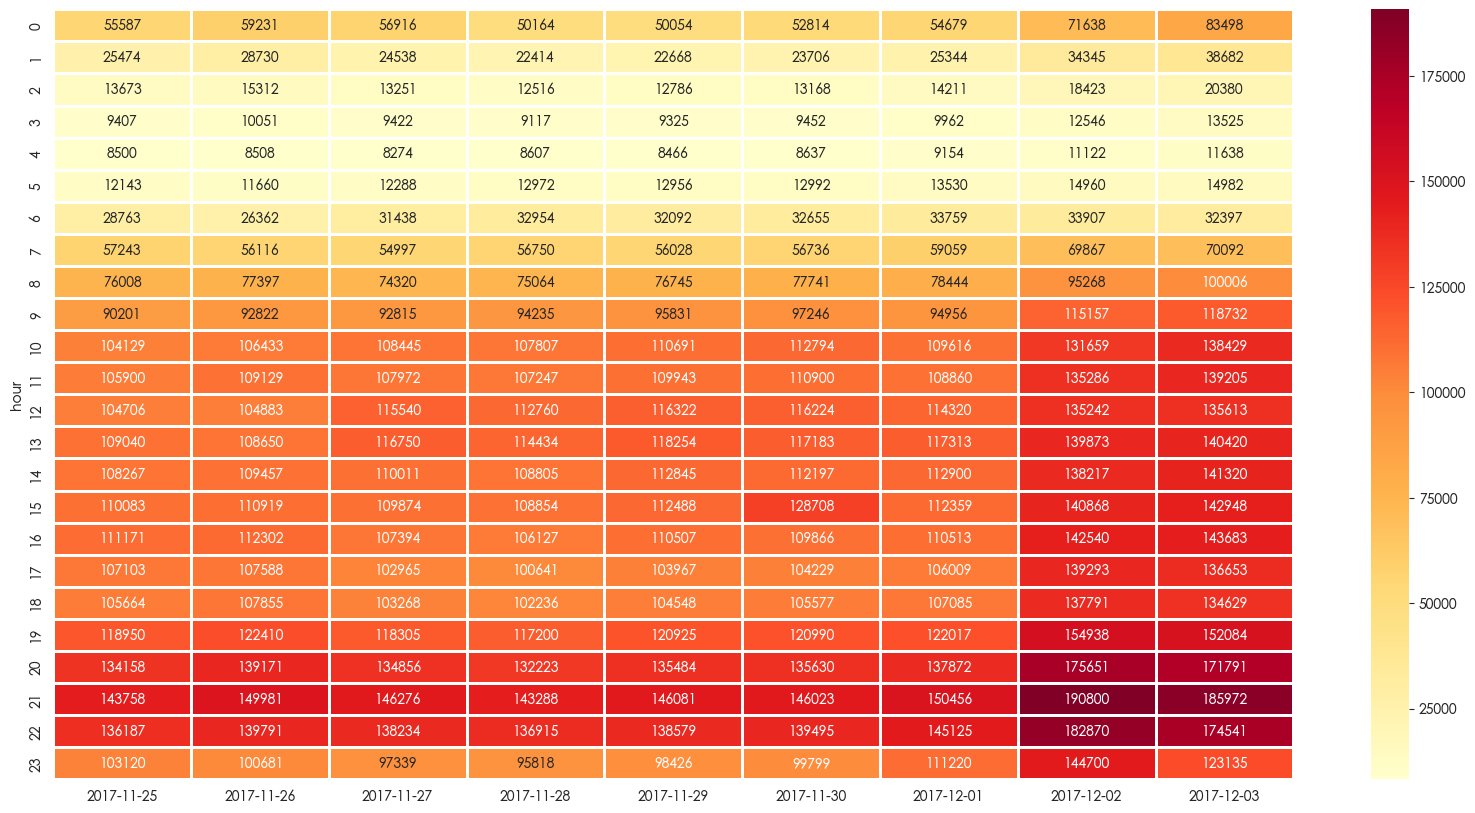

In [25]:
# 每天每小时的活跃用户数
agg_taobao = taobao.groupBy('date','hour').agg(count_distinct('user_id').alias('active'))
active_hour = agg_taobao.groupBy('hour').pivot('date').agg(first('active')).fillna(0)

active_hour_pd = active_hour.toPandas().set_index('hour')
active_hour_pd.sort_index(ascending=True, inplace=True)
plt.figure(figsize=(20,10))
sns.heatmap(active_hour_pd, cmap='YlOrRd', annot=True, fmt='d' ,linewidths=1)

In [26]:
active_hour.show(5)

+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|hour|2017-11-25|2017-11-26|2017-11-27|2017-11-28|2017-11-29|2017-11-30|2017-12-01|2017-12-02|2017-12-03|
+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  12|    104706|    104883|    115540|    112760|    116322|    116224|    114320|    135242|    135613|
|  22|    136187|    139791|    138234|    136915|    138579|    139495|    145125|    182870|    174541|
|   1|     25474|     28730|     24538|     22414|     22668|     23706|     25344|     34345|     38682|
|  13|    109040|    108650|    116750|    114434|    118254|    117183|    117313|    139873|    140420|
|  16|    111171|    112302|    107394|    106127|    110507|    109866|    110513|    142540|    143683|
+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+
only showing top 5 rows


In [27]:
active_hour_pd.to_csv('output/active_hour.csv')

<Figure size 800x400 with 0 Axes>

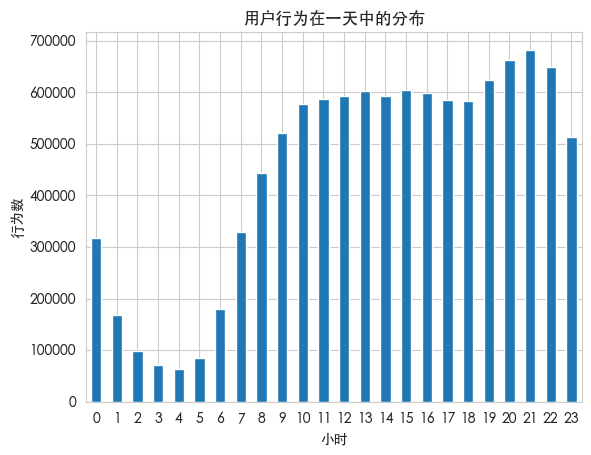

In [28]:
# 每小时的活跃用户数
hourly_actions = taobao.groupBy('hour').agg(count_distinct('user_id').alias('active'))

hourly_actions_pd = hourly_actions.toPandas()
hourly_actions_pd.sort_values(by='hour', ascending=True, inplace=True)

plt.rcParams['font.family'] = 'Heiti TC'
plt.figure(figsize=(8,4))
hourly_actions_pd.plot.bar(x='hour',y='active',rot=0, legend=False)
plt.title('用户行为在一天中的分布')
plt.xlabel('小时')
plt.ylabel('行为数')
plt.show()

In [30]:
hourly_actions_pd.to_csv("output/hourly_actions.csv")

<Axes: ylabel='hour'>

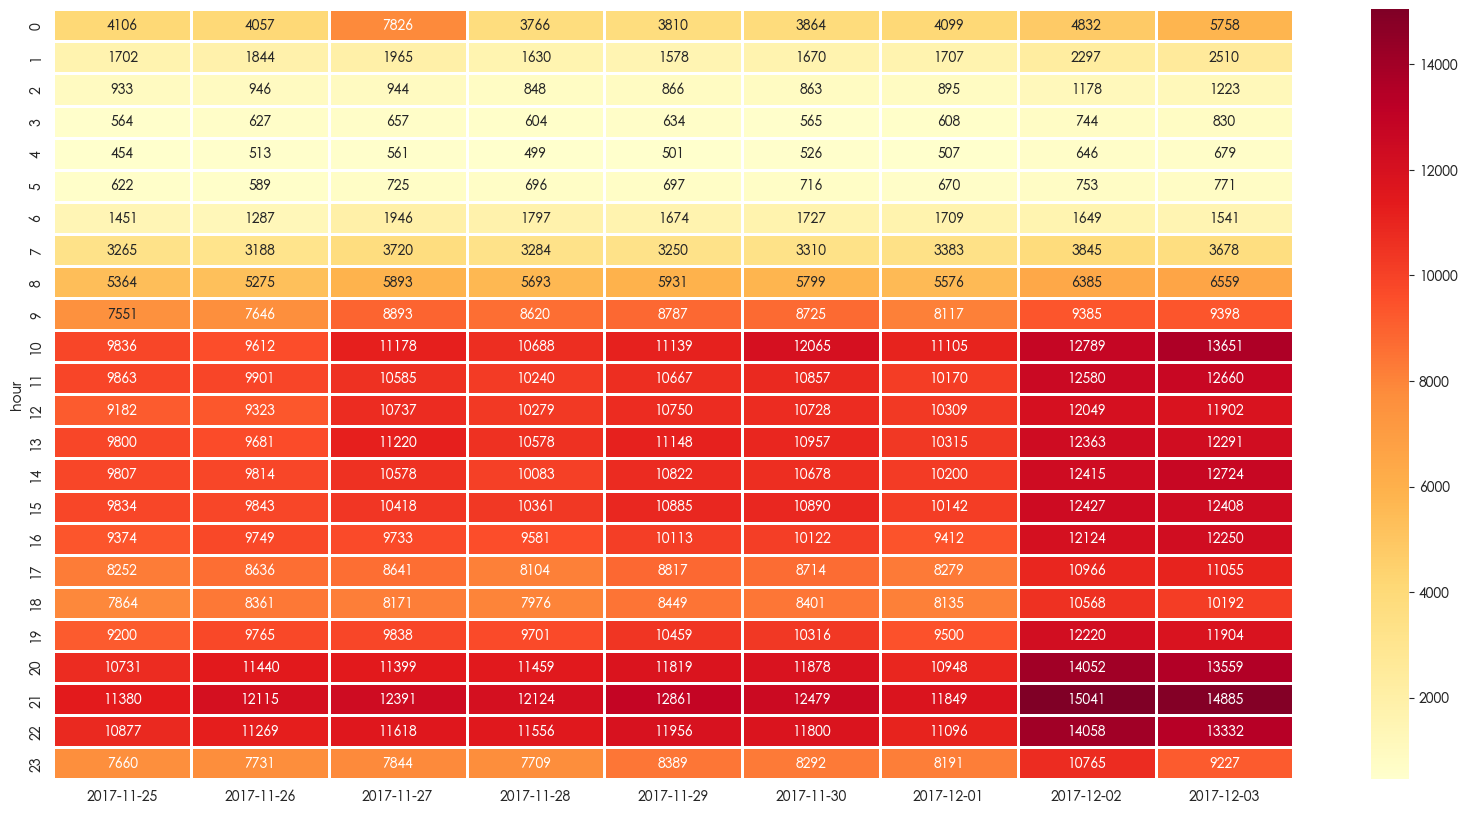

In [31]:
# active_buy_hour = taobao[taobao['behavior_type']=='buy'].pivot_table(index='hour', columns='date', values='user_id', aggfunc='nunique', fill_value=0)

active_buy_hour_agg = taobao.filter(col('behavior_type')=='buy').groupBy('date','hour').agg(count_distinct('user_id').alias('active'))
active_buy_hour = active_buy_hour_agg.groupBy('hour').pivot('date').agg(first('active')).fillna(0)

active_buy_hour_pd = active_buy_hour.toPandas().set_index('hour')
active_buy_hour_pd.sort_index(ascending=True, inplace=True)

plt.figure(figsize=(20,10))
sns.heatmap(active_buy_hour_pd, cmap='YlOrRd', annot=True, fmt='d' ,linewidths=1)


In [32]:
active_buy_hour_pd.to_csv("output/active_buy_hour.csv")

### 产品数据探索

找到Top热门商品/类别——热门产品Top10

1. 流量热度
2. 销量热度
3. 综合热度

In [11]:
from itertools import chain
# 产品热度
heat_score = {'pv':1, 'fav':3, 'cart':5, 'buy':10}

# 流量热度
pv_top10 = taobao.filter(col('behavior_type')=='pv').groupBy('item_id').agg(count("item_id").alias('count')).orderBy(desc('count'))

# 销量热度
sale_top10 = taobao.filter(col('behavior_type')=='buy').groupBy('item_id').agg(count("item_id").alias('count')).orderBy(desc('count'))

# 综合热度
mapping_expr = create_map([lit(x) for x in chain(*heat_score.items())])
taobao = taobao.withColumn("score_heat", mapping_expr[col("behavior_type")])
heat_top10_item = taobao.groupBy('item_id').agg(sum(col('score_heat')).alias('total_heat')).orderBy(desc('total_heat'))

# # 综合表
pv_top10_pd = pv_top10.limit(10).toPandas()
sale_top10_pd = sale_top10.limit(10).toPandas()
heat_top10_item_pd = heat_top10_item.limit(10).toPandas()
items_top10 = pd.concat([pv_top10_pd, sale_top10_pd, heat_top10_item_pd], axis=1, keys=['pv_top10','sale_top10','heat_top10_item'])

# items_top10
items_top10.head(10)


ERROR:root:KeyboardInterrupt while sending command.               (18 + 2) / 34]
Traceback (most recent call last):
  File "/Users/yujiewang/anaconda3/envs/Conda11/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yujiewang/anaconda3/envs/Conda11/lib/python3.11/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yujiewang/anaconda3/envs/Conda11/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [35]:
items_top10.to_csv("output/items_top10.csv")

In [10]:
# 产品类别数目

# 流量热度
pv_cat_top10 = taobao.filter(col('behavior_type')=='pv').groupBy('item_category').agg(count('item_category').alias('count'))

# 销量热度
sale_cat_top10 = taobao.filter(col('behavior_type')=='buy').groupBy('item_category').agg(count('item_category').alias('count'))

# 综合热度
heat_top10_cat = taobao.groupBy('item_category').agg(sum('score_heat').alias('total_heat')).orderBy(desc('total_heat'))

pv_cat_top10_pd = pv_cat_top10.limit(10).toPandas()
sale_cat_top10_pd = sale_top10.limit(10).toPandas()
heat_top10_cat_pd = heat_top10_cat.limit(10).toPandas()

cat_top10 = pd.concat([pv_cat_top10_pd, sale_cat_top10_pd, heat_top10_cat_pd], axis=1, keys=['cat_pv_top10','cat_sale_top10','heat_top10_cat'])
cat_top10.head(10)

{"ts": "2025-09-09 22:42:53.437", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `score_heat` cannot be resolved. Did you mean one of the following? [`date`, `hour`, `item_id`, `time`, `user_id`]. SQLSTATE: 42703", "context": {"file": "jdk.internal.reflect.GeneratedMethodAccessor67.invoke(Unknown Source)", "line": "", "fragment": "col", "errorClass": "UNRESOLVED_COLUMN.WITH_SUGGESTION"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o227.agg.\n: org.apache.spark.sql.AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `score_heat` cannot be resolved. Did you mean one of the following? [`date`, `hour`, `item_id`, `time`, `user_id`]. SQLSTATE: 42703;\n'Aggregate [item_category#24], [item_category#24, 'sum('score_heat) AS total_heat#258]\n+- Filter ((date#182 >= 2017-11-25) AND (date#182 <= 2017-

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `score_heat` cannot be resolved. Did you mean one of the following? [`date`, `hour`, `item_id`, `time`, `user_id`]. SQLSTATE: 42703;
'Aggregate [item_category#24], [item_category#24, 'sum('score_heat) AS total_heat#258]
+- Filter ((date#182 >= 2017-11-25) AND (date#182 <= 2017-12-03))
   +- Project [user_id#22, item_id#23, item_category#24, behavior_type#25, timestamp#26, time#181, to_date(time#181, None, Some(Asia/Shanghai), false) AS date#182, hour(time#181, Some(Asia/Shanghai)) AS hour#183, date_format(time#181, EEEE, Some(Asia/Shanghai)) AS weekday#184]
      +- Project [user_id#22, item_id#23, item_category#24, behavior_type#25, timestamp#26, cast(from_unixtime(cast(timestamp#26 as bigint), yyyy-MM-dd HH:mm:ss, Some(Asia/Shanghai)) as timestamp) AS time#181]
         +- Deduplicate [item_id#23, timestamp#26, user_id#22, item_category#24, behavior_type#25]
            +- Project [_c0#17 AS user_id#22, _c1#18 AS item_id#23, _c2#19 AS item_category#24, _c3#20 AS behavior_type#25, _c4#21 AS timestamp#26]
               +- Relation [_c0#17,_c1#18,_c2#19,_c3#20,_c4#21] csv


In [ ]:
cat_top10.to_csv("output/item_category_top10.csv")

综合热度：可以设置权重
1. 经验法 ✅ —— pv =1, fav=3, cart=5, buy=10
2. 数据驱动法——转化率倒数 ❓
3. 模型学习法

In [28]:
# 计算综合热度top10产品所占的总的行为次数
top_10_items =  items_top10['heat_top10_item']['item_id'].tolist()
top10_behavior_count = taobao[taobao['item_id'].isin(top_10_items)].select(count(col('behavior_type')).alias('count')).collect()[0]['count']
top10_ratio = 100*top10_behavior_count/taobao.count()
print(f"Top10 商品占据了{top10_ratio:.3f}%的总行为数")

Top10 商品占据了0.210%的总行为数


## 阶段四：核心业务分析

转化漏洞+用户画像/分层

### 转化漏斗分析

目标：分析用户从浏览-> 收藏/加购 -> 购买 的转化情况， 找到流失最多的环节

**方法一**：粗略计算

- 思路：

    - 按行为类型依次筛选用户集合，用 user_id.nunique() 做去重。
- 优点：
    - 清晰、逻辑直观。
    - 回答“浏览后多少人收藏/加购，再多少人购买”等问题。
- 缺点：
    - 路径信息丢失：比如无法区分「浏览→直接购买」和「浏览→收藏→购买」。
    - 如果你想分析「无浏览直接收藏→购买」的用户群，这种写法就难以扩展。

👉 适合 做大盘用户行为转化率，但不够灵活。

In [29]:
# 计算浏览的人数
pv_users = taobao[taobao['behavior_type']=='buy'][['user_id']]
pv_users_count = taobao[taobao['behavior_type']=='pv'].select(count_distinct('user_id').alias('count')).collect()[0]['count']

# # 所有收藏/加购的人数
fav_cart_user = taobao[taobao['behavior_type'].isin(['fav','cart'])][['user_id']]
#
# # 浏览后，收藏加购的人数 - 浏览 -> 收藏加购
pv_fav_cart_user = fav_cart_user[fav_cart_user['user_id'].isin(pv_users['user_id'])][['user_id']]
pv_fav_cart_user_count = pv_fav_cart_user.agg(count_distinct('user_id').alias('count')).collect()[0]['count']
#
# # 所有购买的人数
buy_users = taobao[taobao['behavior_type']=='buy'][['user_id']]
#
# # 浏览- 收藏加购后，购买的人数 - 浏览 -> 收藏加购 -> 购买
pv_favcart_buy_user = buy_users[buy_users['user_id'].isin(pv_fav_cart_user['user_id'])][['user_id']]
pv_favcart_buy_user_count = pv_favcart_buy_user.agg(count_distinct('user_id').alias('count')).collect()[0]['count']
#
# # 浏览后直接购买的人数（无收藏加购）—— 浏览-> 购买
pv_buy_user = buy_users[buy_users['user_id'].isin(pv_users['user_id'])][['user_id']]
pv_buy_user_count = pv_buy_user.agg(count_distinct('user_id').alias('count')).collect()[0]['count']
# # ----- 计算转化率-------
# # 浏览->收藏加购转化率
rate_pv_favcart = 100*pv_fav_cart_user_count/pv_users_count
# # 浏览收藏加购-> 购买转化率
rate_pv_favcart_buy = 100*pv_favcart_buy_user_count/pv_fav_cart_user_count
# # 整体转化率 - 所有浏览后购买人数（包含收藏加购）/所有浏览人数
rate_pv_buy = 100*pv_buy_user_count/pv_users_count

print(f"浏览->收藏/加购 转化率: {rate_pv_favcart:.2f}%")
print(f"浏览收藏加购->购买 转化率: {rate_pv_favcart_buy:.2f}%")
print(f"整体转化率:{rate_pv_buy:.2f}%")

浏览->收藏/加购 转化率: 87.32%
浏览收藏加购->购买 转化率: 78.25%
整体转化率:68.33%


**方法二**：构造行为路径（user_id, item_id 粒度）

In [30]:
user_behavior = taobao[['user_id','item_id','behavior_type']]
users = user_behavior.withColumn("flag", lit(1)).groupBy('user_id','item_id').pivot("behavior_type", ["pv","fav","cart","buy"]).max('flag').fillna(0).withColumnRenamed('pv','pv_cnt').withColumnRenamed('fav','fav_cnt').withColumnRenamed('cart','cart_cnt').withColumnRenamed('buy','buy_cnt')
users.show(5)


+-------+-------+------+-------+--------+-------+
|user_id|item_id|pv_cnt|fav_cnt|cart_cnt|buy_cnt|
+-------+-------+------+-------+--------+-------+
|1000274|3674672|     1|      0|       0|      0|
|1001334|2985647|     0|      0|       1|      0|
|1003146|4162448|     1|      0|       0|      0|
|1004192|2807767|     1|      0|       0|      0|
|1004337| 527037|     1|      0|       0|      0|
+-------+-------+------+-------+--------+-------+
only showing top 5 rows


In [31]:
users = users.withColumn('user_behavior_path', concat_ws("", col('pv_cnt').cast("string"), col('fav_cnt').cast("string"), col('cart_cnt').cast("string"), col('buy_cnt').cast("string")))
users.show(5)

+-------+-------+------+-------+--------+-------+------------------+
|user_id|item_id|pv_cnt|fav_cnt|cart_cnt|buy_cnt|user_behavior_path|
+-------+-------+------+-------+--------+-------+------------------+
|1000274|3674672|     1|      0|       0|      0|              1000|
|1001334|2985647|     0|      0|       1|      0|              0010|
|1003146|4162448|     1|      0|       0|      0|              1000|
|1004192|2807767|     1|      0|       0|      0|              1000|
|1004337| 527037|     1|      0|       0|      0|              1000|
+-------+-------+------+-------+--------+-------+------------------+
only showing top 5 rows


In [32]:
# 浏览 - 收藏/加购 - 购买 行为路径转化率
# 漏斗第一层：浏览的用户数量
pvs = users[users['pv_cnt']==1].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
print(f"浏览的用户数量:{pvs:.2f}")

# 漏斗第二层：浏览后收藏或加购的用户数量
fav_cart_user = users[(users['pv_cnt']==1)&((users['fav_cnt']==1)|(users['cart_cnt']==1))].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
print(f"浏览后收藏或加购物车的用户数量:{fav_cart_user:.2f}")

# # 漏斗第三层：浏览-收藏/加购-最后购买的用户数量
buys = users[users['user_behavior_path'].isin(['1101','1111','1011'])].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
print(f"最后购买的用户数量:{buys:.2f}")

pv_fav_cart_con = 100*fav_cart_user/pvs
pv_favcart_buy_con = 100*buys/fav_cart_user

print(f"浏览->收藏/加购 转化率: {pv_fav_cart_con:.2f}%")
print(f"浏览收藏加购->购买 转化率: {pv_favcart_buy_con:.2f}%")

# # 浏览->购买的转化率（包含收藏加购）
all_buys_from_pv = users[users['user_behavior_path'].isin(['1101','1111','1011','1001'])].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
buys_from_pv_rate = 100*all_buys_from_pv/pvs
print(f"浏览->购买 转化率:{buys_from_pv_rate:.2f}%")

# # 收藏加购->购买的转化率(包含浏览和无浏览)
all_buys_from_favcart = users[(users['buy_cnt']==1)&((users['fav_cnt']==1)|(users['cart_cnt']==1))].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
all_favcart = users[(users['fav_cnt']==1)|(users['cart_cnt']==1)].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
buys_from_favcart = 100*all_buys_from_favcart/all_favcart
print(f"收藏加购->购买 转化率:{buys_from_favcart:.2f}%")

# # 浏览后直接购买的比例
buys_without_favcart = users[users['user_behavior_path']=='1001'].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
direct_buy_pv = 100*buys_without_favcart/pvs
print(f"浏览->购买(直购): {direct_buy_pv:.2f}%")

# # 无浏览，直接收藏加购->购买 比例：
buys_without_pv = users[users['user_behavior_path'].isin(['0101','0111','0011'])].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
favcart_without_pv = users[((users['fav_cnt']==1)|(users['cart_cnt']==1))&(users['pv_cnt']==0)].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
direct_cart_buy = 100*buys_without_pv/favcart_without_pv
print(f"直接收藏加购->购买: {direct_cart_buy:.2f}%")

# # 该时间段内，没有浏览/收藏/加购，直接购买的用户比例
direct_buys = users[users['user_behavior_path']=='0001'].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
all_buy_users = users[users['buy_cnt']==1].agg(count_distinct('user_id').alias('count')).collect()[0]['count']
direct_buy_rate = 100*direct_buys/all_buy_users
print(f"所有购买过商品的用户中，无浏览/收藏/加购，直接购买的用户:{direct_buy_rate:.2f}%")

浏览的用户数量:984105.00


浏览后收藏或加购物车的用户数量:735786.00


最后购买的用户数量:241072.00
浏览->收藏/加购 转化率: 74.77%
浏览收藏加购->购买 转化率: 32.76%


浏览->购买 转化率:56.59%


收藏加购->购买 转化率:33.75%


浏览->购买(直购): 46.95%


直接收藏加购->购买: 11.21%


所有购买过商品的用户中，无浏览/收藏/加购，直接购买的用户:46.17%


### 用户分层分析（RFM模型）

**目标**：识别高价值用户、中低价值用户，进行用户画像。

In [33]:
# 创建RF表格
all_rebuys = taobao[taobao['behavior_type']=='buy']
all_rebuys.show(5)

+-------+-------+-------------+-------------+----------+-------------------+----------+----+---------+----------+
|user_id|item_id|item_category|behavior_type| timestamp|               time|      date|hour|  weekday|score_heat|
+-------+-------+-------------+-------------+----------+-------------------+----------+----+---------+----------+
|1000151|4828228|      2033408|          buy|1512272985|2017-12-03 11:49:45|2017-12-03|  11|   Sunday|        10|
|1000228|3815973|      4339722|          buy|1511940698|2017-11-29 15:31:38|2017-11-29|  15|Wednesday|        10|
|1002031| 406546|      3425243|          buy|1512272169|2017-12-03 11:36:09|2017-12-03|  11|   Sunday|        10|
|1003627|1104473|      1029306|          buy|1512279796|2017-12-03 13:43:16|2017-12-03|  13|   Sunday|        10|
|1004584|1168346|      4331400|          buy|1511705127|2017-11-26 22:05:27|2017-11-26|  22|   Sunday|        10|
+-------+-------+-------------+-------------+----------+-------------------+----------+-

In [34]:
rf = all_rebuys.groupBy('user_id').agg(
    max('date').alias('recency'),
    count('date').alias('frequency')
)


# 关键：把 datetime.date 转回 datetime64[ns]
today = pd.Timestamp('2017-12-04').normalize()
rf = rf.withColumn('recency', to_date('recency'))
rf = rf.withColumn('recency', datediff(lit(today), col('recency')))
rf.show(5)

+-------+-------+---------+
|user_id|recency|frequency|
+-------+-------+---------+
| 103902|      5|        6|
| 150822|      1|        1|
| 153409|      1|        3|
|1009575|      1|        2|
| 137793|      1|        2|
+-------+-------+---------+
only showing top 5 rows


<Axes: ylabel='Frequency'>

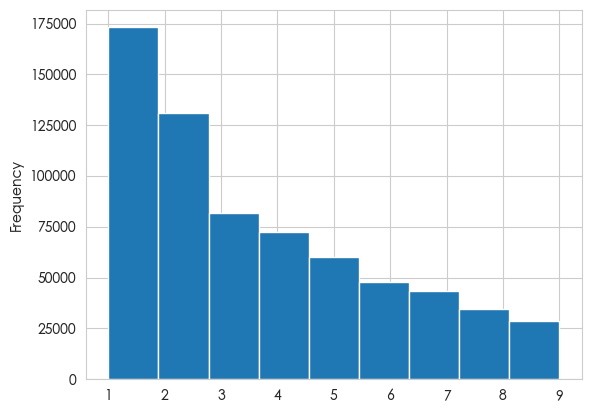

In [35]:
# 查看RF分布
recency_pd = rf[['recency']].toPandas()
recency_pd.plot.hist(bins=9, legend=False)

我从数据中观察到，数据出现了右偏分布，其中recency为1的数据占比较大，如果简单实用等规模分箱法，会导致因为同一频率会被赋予不同的分值。比如等计数分成5组，每组是20%的数据，那么recency为1的数据早已超过了20%，其中必然有一部分数据被安排给下一组，就会被赋予不同的分值。因此此处不能使用等规模分箱法。

In [36]:
# recency = rf['recency'].value_counts()
recency = rf.groupBy('recency').agg(count('recency').alias('count'))
recency.show(5)

+-------+------+
|recency| count|
+-------+------+
|      1|173225|
|      6| 47751|
|      3| 81908|
|      5| 60103|
|      9| 28572|
+-------+------+
only showing top 5 rows


针对这个问题，我采用了业务方法，根据分布情况，将：
- recency = 1 ——> 5
- recency = 2、3 ——> 4
- recency = 4、5 ——> 3
- recency = 6、7 ——> 2
- recency = 8、9 ——> 1

In [37]:
# Rscore
r_score = {1:5,2:4,3:4,4:3,5:3,6:2,7:2,8:1,9:1}
score_map = create_map([lit(x) for x in chain(*r_score.items())])
rf = rf.withColumn('r_score', score_map[col('recency')])
rf.show(5)

+-------+-------+---------+-------+
|user_id|recency|frequency|r_score|
+-------+-------+---------+-------+
| 103902|      5|        6|      3|
| 150822|      1|        1|      5|
| 153409|      1|        3|      5|
|1009575|      1|        2|      5|
| 137793|      1|        2|      5|
+-------+-------+---------+-------+
only showing top 5 rows


<Axes: xlabel='frequency'>

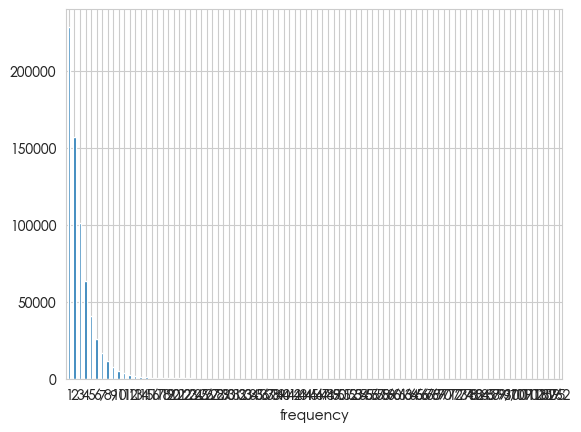

In [38]:
# 查看f分布
frequency = rf.groupBy('frequency').agg(count('frequency').alias('count')).orderBy(asc('frequency'))
frequency_pd = frequency.toPandas()
frequency_pd.plot.bar(x='frequency',y='count',rot=0, legend=False)

In [39]:
# 计算f score
import math
def freq_to_score_piecewise(freq_series, low_cut=5, n_score=5):
    import builtins
    max_ = builtins.max
    min_ = builtins.min
    freq = np.sort(freq_series.unique())

    low_freq = freq[freq<=low_cut]
    high_freq = freq[freq>low_cut]

    mapping = {}
    low_score_max = max_(1, n_score//2)

    low_bins = np.linspace(1, low_score_max+1, num=len(low_freq), endpoint=True)
    for v, s in zip(low_freq, np.ceil(low_bins).astype(int)):
        mapping[int(v)] = int(min_(max_(1,s),n_score))

    high_log = np.log1p(high_freq)
    hl_min, hl_max = high_log.min(), high_log.max()
    high_norm = (high_log - hl_min)/(hl_max - hl_min)
    target_low = low_score_max + 1
    target_high = n_score
    for v, hn in zip(high_freq, high_norm):
        sc = int(np.ceil(target_low+hn*(target_high-target_low)))
        mapping[int(v)] = sc

    return mapping


rf_frequency = rf[['frequency']].toPandas()
mapping = freq_to_score_piecewise(rf_frequency['frequency'], low_cut=5, n_score=5)
f_map = create_map([lit(x) for x in chain(*mapping.items())])
rf = rf.withColumn("f_score", f_map[col('frequency')]).fillna(1)
freq_table = rf.groupBy('f_score').agg(count('f_score').alias('user_count')).orderBy(asc('f_score'))
freq_sum = freq_table.agg(sum(col('user_count')).alias('count')).collect()[0]['count']
freq_table = freq_table.withColumn('pct', round(freq_table['user_count']/lit(freq_sum),6))
freq_table.show(5)

+-------+----------+--------+
|f_score|user_count|     pct|
+-------+----------+--------+
|      1|    228546|0.339894|
|      2|    258173|0.383955|
|      3|    129588|0.192723|
|      4|     55941|0.083196|
|      5|       156| 2.32E-4|
+-------+----------+--------+



In [40]:
agg_vals = rf.agg(
    round(mean("r_score"), 2).alias("r_avg"),
    round(mean("f_score"), 2).alias("f_avg")
).collect()[0]

r_avg = agg_vals['r_avg']
f_avg = agg_vals['f_avg']

rf = rf.withColumns({'r_avg': lit(r_avg), 'f_avg': lit(f_avg)})

rf = rf.withColumn('user_cate', when((col('r_score')>col('r_avg'))&(col('f_score')>col('f_avg')), '价值用户')
                   .when((col('r_score')>col('r_avg'))&(col('f_score')<=col('f_avg')), '发展用户')
                   .when((col('r_score')<col('r_avg'))&(col('f_score')>col('f_avg')), '保持用户')
                   .otherwise('挽留用户'))
rf.show(5)

+-------+-------+---------+-------+-------+-----+-----+---------+
|user_id|recency|frequency|r_score|f_score|r_avg|f_avg|user_cate|
+-------+-------+---------+-------+-------+-----+-----+---------+
| 103902|      5|        6|      3|      3| 3.51| 2.02| 保持用户|
| 150822|      1|        1|      5|      1| 3.51| 2.02| 发展用户|
| 153409|      1|        3|      5|      2| 3.51| 2.02| 发展用户|
|1009575|      1|        2|      5|      2| 3.51| 2.02| 发展用户|
| 137793|      1|        2|      5|      2| 3.51| 2.02| 发展用户|
+-------+-------+---------+-------+-------+-----+-----+---------+
only showing top 5 rows


In [41]:
segments = rf.groupBy('user_cate').agg(count('user_cate').alias('count')).orderBy(desc('count'))
segments.show()

+---------+------+
|user_cate| count|
+---------+------+
| 挽留用户|243628|
| 发展用户|243091|
| 价值用户|142836|
| 保持用户| 42849|
+---------+------+



### 用户留存分析
计算用户留存率

In [42]:
user_login_date = taobao[['user_id','date']].dropDuplicates()
user_login_date = user_login_date.withColumn('date', to_date('date'))
first_login = user_login_date.groupBy('user_id').agg(min('date').alias('first_login'))
first_login.show(5)

+-------+-----------+
|user_id|first_login|
+-------+-----------+
|1000636| 2017-11-25|
|1001601| 2017-11-26|
|1002431| 2017-11-25|
| 100274| 2017-11-25|
|1003938| 2017-11-26|
+-------+-----------+
only showing top 5 rows


In [43]:
user_active = user_login_date.join(first_login, on='user_id', how='left')
user_active = user_active.withColumn('datediff', datediff('date', 'first_login'))
user_active.show(5)

+-------+----------+-----------+--------+
|user_id|      date|first_login|datediff|
+-------+----------+-----------+--------+
|1000423|2017-12-02| 2017-11-25|       7|
|1000546|2017-12-01| 2017-11-25|       6|
|1000565|2017-11-27| 2017-11-25|       2|
|1000664|2017-11-28| 2017-11-25|       3|
|1000749|2017-11-27| 2017-11-25|       2|
+-------+----------+-----------+--------+
only showing top 5 rows


In [44]:
retention = user_active.groupBy('first_login').agg(
    count_distinct('user_id').alias('total_users'),
    count_distinct(when(user_active['datediff']==1, col('user_id'))).alias('d1_users'),
    count_distinct(when(user_active['datediff']==3, col('user_id'))).alias('d3_users')
).withColumns({
    'ret_1': round(100*(col('d1_users')/col('total_users')),2),
    'ret_3': round(100*(col('d3_users')/col('total_users')),2)
}).orderBy(asc('first_login'))

retention.show(5)

+-----------+-----------+--------+--------+-----+-----+
|first_login|total_users|d1_users|d3_users|ret_1|ret_3|
+-----------+-----------+--------+--------+-----+-----+
| 2017-11-25|     706641|  557328|  536463|78.87|75.92|
| 2017-11-26|     158188|  103431|  104190|65.38|65.86|
| 2017-11-27|      63825|   39280|   41082|61.54|64.37|
| 2017-11-28|      31331|   19366|   20805|61.81| 66.4|
| 2017-11-29|      17931|   12512|   17315|69.78|96.56|
+-----------+-----------+--------+--------+-----+-----+
only showing top 5 rows


In [45]:
# cohort_data = user_active.groupby(['first_login', 'datediff'])['user_id'].nunique().reset_index()
# # 每个 cohort 的新用户数
# new_users = cohort_data[cohort_data['datediff']==0][['first_login','user_id']]
# new_users.rename(columns={'user_id':'new_user_count'}, inplace=True)
# cohort_data = cohort_data.merge(new_users, on='first_login', how='left')
# cohort_data['retention_rate'] = round(cohort_data['user_id'] / cohort_data['new_user_count'],3)
# cohort_data

cohort_data = user_active.groupBy('first_login','datediff').agg(count_distinct('user_id').alias('users_count'))
new_users = cohort_data.filter(col('datediff')==0).select("first_login",col("users_count").alias('new_users_count'))
cohort_data = cohort_data.join(new_users, on='first_login', how='left')
cohort_data = cohort_data.withColumn('retention_rate', round(col('users_count')/col('new_users_count'),3))
cohort_data.show(5)

+-----------+--------+-----------+---------------+--------------+
|first_login|datediff|users_count|new_users_count|retention_rate|
+-----------+--------+-----------+---------------+--------------+
| 2017-11-26|       1|     103431|         158188|         0.654|
| 2017-11-26|       7|     154003|         158188|         0.974|
| 2017-11-25|       7|     696406|         706641|         0.986|
| 2017-11-25|       0|     706641|         706641|           1.0|
| 2017-11-25|       4|     537610|         706641|         0.761|
+-----------+--------+-----------+---------------+--------------+
only showing top 5 rows


In [46]:
retention = cohort_data.groupBy('first_login').pivot('datediff').agg(mean('retention_rate').alias('retention_rate')).fillna(0).drop('0')
for c in retention.columns:
    if c!='first_login':
        retention = retention.withColumnRenamed(c, f'ret_{c}')

In [47]:
retention_pd = retention.toPandas()
retention_pd.set_index('first_login', inplace=True)
retention_pd.sort_index(ascending=True, inplace=True)

<Axes: ylabel='first_login'>

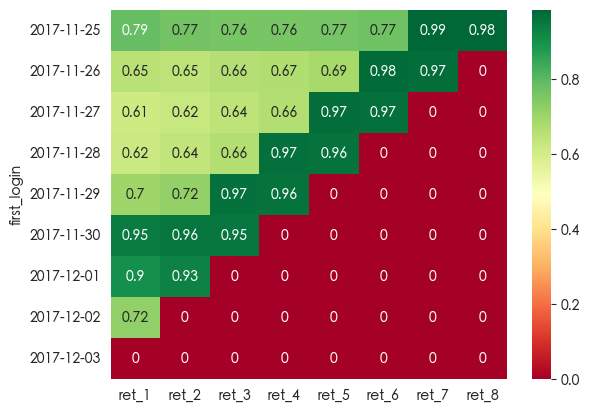

In [48]:
sns.heatmap(retention_pd, cmap='RdYlGn',annot=True)

### 用户获取分析

In [49]:
# 计算pv, uv, pv/uv
pv_user = taobao[taobao['behavior_type']=='pv'].groupBy('date').agg(
    count('behavior_type').alias('pv'),
    count_distinct('user_id').alias('uv')
).withColumn('pv/uv', round(col('pv')/col('uv'),2)).orderBy(asc('date'))
pv_user.show()

+----------+--------+------+-----+
|      date|      pv|    uv|pv/uv|
+----------+--------+------+-----+
|2017-11-25| 9353416|686953|13.62|
|2017-11-26| 9567422|695869|13.75|
|2017-11-27| 9041186|689260|13.12|
|2017-11-28| 8842932|688042|12.85|
|2017-11-29| 9210820|697542| 13.2|
|2017-11-30| 9358998|709586|13.19|
|2017-12-01| 9718956|718184|13.53|
|2017-12-02|12329641|939383|13.13|
|2017-12-03|12237300|936431|13.07|
+----------+--------+------+-----+



### 商品分析

计算复购率

In [50]:
# 计算统计时间内的复购率，一天的算一单
# 筛选出所有购买记录， 根据日期和user_id进行分组
all_rebuys = taobao[taobao['behavior_type']=='buy'].groupBy('date','user_id').agg(count_distinct('item_id').alias('one_day'))

# 根据user_id进行分组，计算不同日期均有购买的user_id
rebuy_user = all_rebuys.groupBy('user_id').agg(count_distinct('date').alias('counts'))
rebuy_user = rebuy_user.withColumn('rebuy', when(col('counts')>1,1).otherwise(0))
rebuy_rate_days = rebuy_user.select(mean('rebuy').alias('rebuys')).collect()[0]['rebuys']
print(f"复购率: {100*rebuy_rate_days:.2f}%")

25/09/09 19:44:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE

复购率: 55.07%


In [51]:
items = taobao.groupBy('item_category').agg(
    sum(when(col('behavior_type')=='pv',1).otherwise(0)).alias('pv'),
    count_distinct('user_id').alias('uv'),
    sum(when(col('behavior_type')=='cart',1).otherwise(0)).alias('cart'),
    sum(when(col('behavior_type')=='fav',1).otherwise(0)).alias('fav'),
    sum(when(col('behavior_type')=='buy',1).otherwise(0)).alias('buy')
).withColumns({'pv/uv': round(col('pv')/col('uv'),2),'convert_buy_rate':round(col('buy')/col('uv'),2)}).orderBy(desc('convert_buy_rate'), desc('pv/uv'))

items.show(5)

25/09/09 19:45:31 ERROR Inbox: Ignoring error                      (0 + 2) / 28]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apach

Py4JJavaError: An error occurred while calling o3837.showString.
: org.apache.spark.SparkException: Job 275 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1301)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1299)
	at scala.collection.mutable.HashSet$Node.foreach(HashSet.scala:450)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:376)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1299)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3234)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:85)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:3120)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:3120)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2346)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2346)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2297)
	at org.apache.spark.SparkContext.$anonfun$new$36(SparkContext.scala:704)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:231)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:205)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1937)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:205)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:205)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:184)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:572)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:317)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)


In [104]:
# items_convert = taobao.groupby(['user_id','item_category']).agg(
#     pv_cnt = ('behavior_type', lambda x: 1 if (x=='pv').sum()>0 else 0),
#     fav_cnt = ('behavior_type', lambda x: 1 if (x=='fav').sum()>0 else 0),
#     cart_cnt = ('behavior_type', lambda x: 1 if (x=='cart').sum()>0 else 0),
#     buy_cnt = ('behavior_type', lambda x: 1 if (x=='buy').sum()>0 else 0)
# ).reset_index()
# items_convert
item_cats = taobao[['user_id','item_category','behavior_type']]
items_convert = (item_cats.withColumn('flag',lit(1)).
                 groupBy('user_id','item_category').pivot('behavior_type',['pv','fav','cart','buy']).max('flag').fillna(0))

items_convert.show(5)

+-------+-------------+---+---+----+---+
|user_id|item_category| pv|fav|cart|buy|
+-------+-------------+---+---+----+---+
| 109233|       523181|  1|  0|   0|  1|
| 463986|      2644484|  1|  0|   1|  1|
| 800993|       149192|  1|  0|   0|  0|
| 114277|      4212922|  1|  0|   0|  0|
| 398203|      2920476|  1|  1|   0|  0|
+-------+-------------+---+---+----+---+
only showing top 5 rows


In [106]:
converts_buy = items_convert.groupBy('item_category').agg(round(mean('buy'),2).alias('buy_rate')).orderBy(desc('buy_rate'))
items = items.join(converts_buy, on='item_category', how='left').fillna(0)
items.show(5)

+-------------+----+---+----+---+---+-----+----------------+--------+
|item_category|  pv| uv|cart|fav|buy|pv/uv|convert_buy_rate|buy_rate|
+-------------+----+---+----+---+---+-----+----------------+--------+
|       903809|3728|885| 256| 86|159| 4.21|            0.18|    0.16|
|      4132735|  69| 26|   4|  1|  2| 2.65|            0.08|    0.08|
|      4174407|  12|  8|   1|  0|  1|  1.5|            0.13|    0.13|
|       214719|   6|  7|   1|  0|  0| 0.86|             0.0|     0.0|
|       754344|   8|  8|   0|  1|  0|  1.0|             0.0|     0.0|
+-------------+----+---+----+---+---+-----+----------------+--------+
only showing top 5 rows


In [110]:
items_scatter = items[['uv','buy_rate']]
# items_scatter['uv_log'] = np.log1p(items_scatter['uv'])
items_scatter = items_scatter.withColumn('uv_log', log1p('uv'))
uvlogs = items_scatter.agg(
    min('uv_log').alias('min_uv_log'),
    max('uv_log').alias('max_uv_log')
).collect()[0]
min_uv_log = uvlogs['min_uv_log']
max_uv_log = uvlogs['max_uv_log']
items_scatter = items_scatter.withColumn('st_uv', round((col('uv_log')-lit(min_uv_log))/(lit(max_uv_log)-lit(min_uv_log)),2))
uv_mean = items_scatter.agg(mean('st_uv').alias('uv_mean')).collect()[0]['uv_mean']
buy_rate_mean = items_scatter.agg(mean('buy_rate').alias('buy_rate_mean')).collect()[0]['buy_rate_mean']

In [113]:
items_scatter.show(5)

+---+--------+------------------+-------------------+
| uv|buy_rate|            uv_log|              st_uv|
+---+--------+------------------+-------------------+
|885|    0.16| 6.786716950605081| 0.7987881877361462|
| 26|    0.08| 3.295836866004329| 0.3411789567579334|
|  8|    0.13|2.1972245773362196|0.19716509424276624|
|  7|     0.0|2.0794415416798357|0.18172526157513635|
|  8|     0.0|2.1972245773362196|0.19716509424276624|
+---+--------+------------------+-------------------+
only showing top 5 rows


<Figure size 1000x600 with 0 Axes>

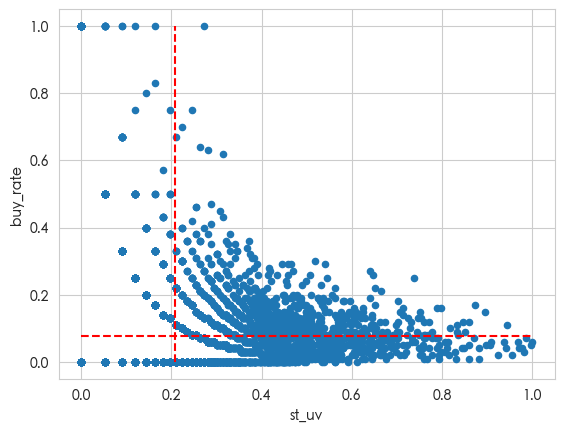

In [115]:
items_scatter = items_scatter.toPandas()

plt.figure(figsize=(10,6))
items_scatter.plot.scatter(x='st_uv',y='buy_rate')
plt.vlines(uv_mean, ymin=0, ymax=1, color='red', linestyles='dashed')
plt.hlines(buy_rate_mean, xmin=0, xmax=1, color='red', linestyles='dashed')